<a href="https://colab.research.google.com/github/iamviji/project/blob/master/misc/PyLDPC_CommPy_ITPP_BER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
!git clone https://github.com/veeresht/CommPy.git
import sys
sys.path.append('./CommPy')

fatal: destination path 'CommPy' already exists and is not an empty directory.


In [123]:
import commpy.channels as chan
import commpy.modulation as mod
import commpy.utilities as util
!pip install pyldpc

In [124]:
import pyldpc
import numpy 
import time


In [125]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 8
num_bits_in_parity_check = 9 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [126]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message



In [127]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 9 channel_size= 18
input_message_size= 9 channel_size= 18
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 0 1 1]
 [0 1 0 ... 1 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 0 ... 1 1 1]
 [0 1 0 ... 0 1 0]]


In [128]:
import commpy
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)    
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc=numpy.append(bler_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 4.78s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 9.52s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 14.28s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 19.48s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 48.05s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 4.24s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 8.66s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 12.73s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 16.85s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 42.48s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 3.23s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 7.21s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 11.15s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 14.87s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 36.47s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 3.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 6.31s
SNR: 1.500 - Iter: 750 - Last 25

In [129]:
modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_modulator  = numpy.array(())
times_per_iter_modulator= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_modulator=numpy.append(bler_per_iter_modulator ,ber)
  times_per_iter_modulator=numpy.append(times_per_iter_modulator, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 4.59s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 9.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 13.50s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 18.12s
SNR: 0.000:
 -> BER: 0.54
 -> Total Time: 45.22s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 3.97s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 7.96s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 12.14s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 16.29s
SNR: 0.500:
 -> BER: 0.47
 -> Total Time: 40.36s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 3.45s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 7.43s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 11.20s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 15.14s
SNR: 1.000:
 -> BER: 0.42
 -> Total Time: 37.22s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 3.09s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 6.63s
SNR: 1.500 - Iter: 750 - Last 25

In [130]:
modem = mod.PSKModem(4) #QPSK
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_qpsk  = numpy.array(())
times_per_iter_qpsk= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_qpsk=numpy.append(bler_per_iter_qpsk ,ber)
  times_per_iter_qpsk=numpy.append(times_per_iter_qpsk, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 5.55s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 10.95s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 16.60s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 21.98s
SNR: 0.000:
 -> BER: 0.81
 -> Total Time: 55.08s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 5.59s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 10.96s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 16.35s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 21.67s
SNR: 0.500:
 -> BER: 0.78
 -> Total Time: 54.58s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 4.98s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 10.19s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 15.45s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 20.52s
SNR: 1.000:
 -> BER: 0.73
 -> Total Time: 51.14s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 4.81s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 9.89s
SNR: 1.500 - Iter: 750 - Last

In [131]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,9))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded  = numpy.array(())
times_per_iter_uncoded= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded=numpy.append(bler_per_iter_uncoded ,ber)
  times_per_iter_uncoded=numpy.append(times_per_iter_uncoded, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 0.000:
 -> BER: 0.53
 -> Total Time: 0.38s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.500:
 -> BER: 0.46
 -> Total Time: 0.43s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.12s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.16s
SNR: 1.000:
 -> BER: 0.41
 -> Total Time: 0.40s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [132]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,10))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_qpsk  = numpy.array(())
times_per_iter_uncoded_qpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_qpsk=numpy.append(bler_per_iter_uncoded_qpsk ,ber)
  times_per_iter_uncoded_qpsk=numpy.append(times_per_iter_uncoded_qpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 0.000:
 -> BER: 0.82
 -> Total Time: 0.38s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 0.500:
 -> BER: 0.80
 -> Total Time: 0.36s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.14s
SNR: 1.000:
 -> BER: 0.76
 -> Total Time: 0.35s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

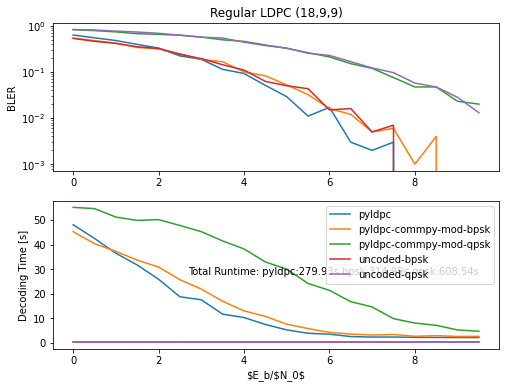

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_modulator,'', label="pyldpc-commpy-mod-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_qpsk,'', label="pyldpc-commpy-mod-qpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded,'', label="uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_qpsk,'', label="uncoded-qpsk") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_modulator,'', label="pyldpc-commpy-mod-bpsk") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_qpsk,'', label="pyldpc-commpy-mod-qpsk") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_uncoded,'', label="uncoded-bpsk") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_uncoded_qpsk,'', label="uncoded-qpsk") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_modulator), numpy.sum(times_per_iter_qpsk)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [134]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/vidits-kth/py-itpp.git
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .  
!cd py-itpp; ls ; pip3 install -e .  
!cat py-itpp/setup.py
import sys
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp # import itpp is not working, after this hack i started to work
sys.path.append('./py-itpp/lib')
#!pip install gwpy &> /dev/null

Reading package lists... Done
Building dependency tree       
Reading state information... Done
autoconf is already the newest version (2.69-11).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtool is already the newest version (2.4.6-2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libblas-dev is already the newest version (3.7.1-4ubuntu1).
libfftw3-dev is already the newest version (3.3.7-1).
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Cloning into 'itpp'...
remote: Enumerating objects: 14431, done.
remote: Total 14431 (delta 0), reused 0 (delta 0), pack-reused 14431
Receiving objects: 100% (14431/14431), 4.88 MiB | 6.83 MiB/s, done.
Resolving deltas: 100% (12154/12154), done.

In [135]:
import pyitpp as itpp
from matplotlib import pyplot as plt

In [136]:
nrof_bits = 9
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_2  = numpy.array(())
times_per_iter_uncoded_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_2=numpy.append(bler_per_iter_uncoded_itpp_psk_2 ,ber)
  times_per_iter_uncoded_itpp_psk_2=numpy.append(times_per_iter_uncoded_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.52
 -> Total Time: 0.05s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.44
 -> Total Time: 0.05s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.40
 -> Total Time: 0.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [137]:
nrof_bits = 9
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_bpsk  = numpy.array(())
times_per_iter_uncoded_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_bpsk=numpy.append(bler_per_iter_uncoded_itpp_bpsk ,ber)
  times_per_iter_uncoded_itpp_bpsk=numpy.append(times_per_iter_uncoded_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.80
 -> Total Time: 0.04s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.76
 -> Total Time: 0.04s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.72
 -> Total Time: 0.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [138]:
nrof_bits = 10
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_4=numpy.append(bler_per_iter_uncoded_itpp_psk_4 ,ber)
  times_per_iter_uncoded_itpp_psk_4=numpy.append(times_per_iter_uncoded_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.83
 -> Total Time: 0.04s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.82
 -> Total Time: 0.04s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.74
 -> Total Time: 0.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

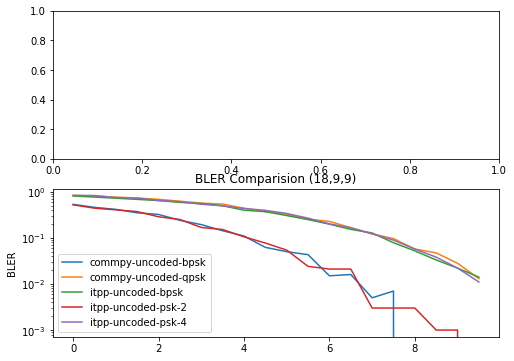

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,bler_per_iter_uncoded,'', label="commpy-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_qpsk,'', label="commpy-uncoded-qpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [140]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_bpsk  = numpy.array(())
times_per_iter_ham_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_bpsk=numpy.append(bler_per_iter_ham_itpp_bpsk ,ber)
  times_per_iter_ham_itpp_bpsk=numpy.append(times_per_iter_ham_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.000:
 -> BER: 0.54
 -> Total Time: 0.08s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BER: 0.45
 -> Total Time: 0.08s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BER: 0.38
 -> Total Time: 0.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [141]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_2  = numpy.array(())
times_per_iter_ham_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_psk_2=numpy.append(bler_per_iter_ham_itpp_psk_2 ,ber)
  times_per_iter_ham_itpp_psk_2=numpy.append(times_per_iter_ham_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BER: 0.20
 -> Total Time: 0.10s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BER: 0.15
 -> Total Time: 0.12s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 1.000:
 -> BER: 0.13
 -> Total Time: 0.09s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [142]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_4  = numpy.array(())
times_per_iter_ham_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    #print ("x")
    #print (source_bits)
    encoded_bits = hamm.encode(source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    #print (demodulated_bits)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_psk_4=numpy.append(bler_per_iter_ham_itpp_psk_4 ,ber)
  times_per_iter_ham_itpp_psk_4=numpy.append(times_per_iter_ham_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BER: 0.54
 -> Total Time: 0.10s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BER: 0.46
 -> Total Time: 0.09s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BER: 0.39
 -> Total Time: 0.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

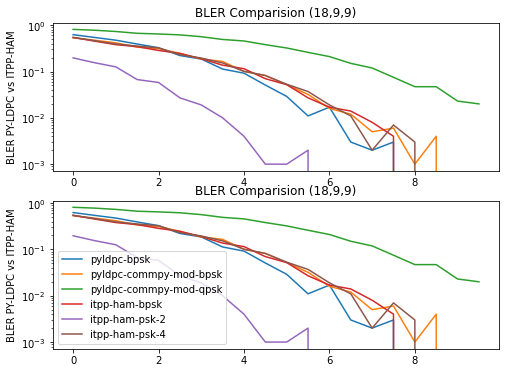

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_modulator,'', label="pyldpc-commpy-mod-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_qpsk,'', label="pyldpc-commpy-mod-qpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_modulator,'', label="pyldpc-commpy-mod-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_qpsk,'', label="pyldpc-commpy-mod-qpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [153]:
import numpy
def bit_error_ratio_uncoded_awgn_bpsk(snr_db):
  
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_bpsk_c(snr_db):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK_c()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_xxx(snr_db, n):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.PSK(n)
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

'''SNR range'''
snrs_db = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)

print('BER Started')
ber_unc_bpsk = [bit_error_ratio_uncoded_awgn_bpsk(snr) for snr in snrs_db]
ber_unc_bpsk_c = [bit_error_ratio_uncoded_awgn_bpsk_c(snr) for snr in snrs_db]
ber_unc_psk_2 = [bit_error_ratio_uncoded_awgn_xxx(snr, 2) for snr in snrs_db]
ber_unc_psk_4 = [bit_error_ratio_uncoded_awgn_xxx(snr, 4) for snr in snrs_db]
ber_unc_psk_8 = [bit_error_ratio_uncoded_awgn_xxx(snr, 8) for snr in snrs_db]
ber_unc_psk_16 = [bit_error_ratio_uncoded_awgn_xxx(snr, 16) for snr in snrs_db]
print('BER Finished')

BER Started
BER Finished


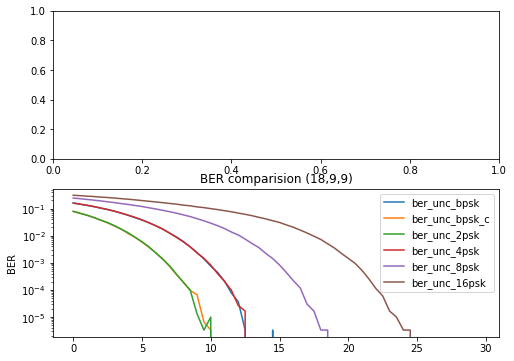

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db,ber_unc_bpsk,'', label="ber_unc_bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_unc_bpsk_c,'', label="ber_unc_bpsk_c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_unc_psk_2,'', label="ber_unc_2psk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_unc_psk_4,'', label="ber_unc_4psk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_unc_psk_8,'', label="ber_unc_8psk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_unc_psk_16,'', label="ber_unc_16psk") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

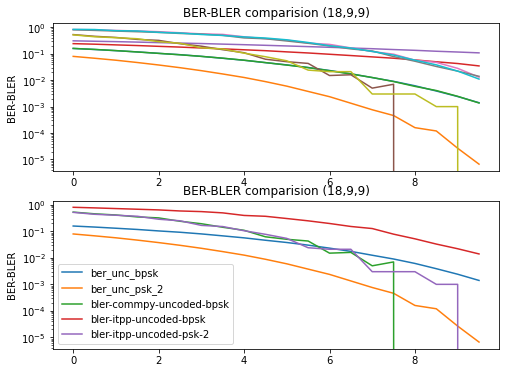

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_unc_bpsk[0:20],'', label="ber_unc_bpsk") # plot BER vs SNR
ax1.semilogy(snrs,ber_unc_bpsk_1[0:20],'', label="ber_unc_psk_2") # plot BER vs SNR
ax1.semilogy(snrs,ber_unc_qpsk[0:20],'', label="ber_unc_qpsk") # plot BER vs SNR
ax1.semilogy(snrs,ber_unc_8psk[0:20],'', label="ber_unc_8psk") # plot BER vs SNR
ax1.semilogy(snrs,ber_unc_16psk[0:20],'', label="ber_unc_16psk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded,'', label="commpy-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_qpsk,'', label="commpy-uncoded-qpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax1.set_ylabel('BER-BLER')
ax1.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax1.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
ax2.semilogy(snrs,ber_unc_bpsk[0:20],'', label="ber_unc_bpsk") # plot BER vs SNR
ax2.semilogy(snrs,ber_unc_bpsk_1[0:20],'', label="ber_unc_psk_2") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_qpsk[0:20],'', label="ber_unc_qpsk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_8psk[0:20],'', label="ber_unc_8psk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_16psk[0:20],'', label="ber_unc_16psk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded,'', label="bler-commpy-uncoded-bpsk") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_qpsk,'', label="commpy-uncoded-qpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.set_ylabel('BER-BLER')
ax2.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()